# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                      
Sample_141  A0A075B6H9                             19.417
Sample_041  Q9NR34                                 16.705
Sample_022  P62942                                 16.318
Sample_193  Q6YHK3                                 14.932
Sample_010  A6XND0;A6XND1;B3KWK7;P17936;P17936-2   16.819
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups 
Sample_046  P15291;P15291-2   16.272
Sample_084  O60243            15.178
Sample_013  P07900;P07900-2   14.308
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.266
            A0A075B6Q5                 12.810
            A0A075B6R2                 13.362
            A0A075B6S5                 13.043
            A0A087WSY4                 12.349
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.118
            Q9UI40;Q9UI40-2            12.699
            Q9UIW2                     12.601
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.190
            Q9UP79                     12.132
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.059,15.050,16.842,19.863,15.777,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.709,19.067,...,15.528,15.576,14.191,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.793,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.317,17.705,17.039,16.149,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.790,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.678,15.345,17.084,18.708,14.249,19.433,11.170,11.029
Sample_207,15.739,16.877,15.469,16.898,14.940,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.266,...,16.012,15.178,12.779,15.050,16.842,19.863,12.554,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.005,19.067,16.188,...,15.528,15.576,12.765,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.805,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.176,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.272,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.896,15.345,17.084,18.708,14.249,19.433,12.238,12.597
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 284.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.48it/s]

100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.65it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.65it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.57it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.50it/s]

100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.85it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.96it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.96it/s]

100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.29it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.83it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.66it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.45it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.45it/s]

100%|██████████| 7/7 [00:01<00:00,  3.45it/s]

100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.81it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.63it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.19it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.07it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.62it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.46it/s]

100%|██████████| 8/8 [00:03<00:00,  2.21it/s]

100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.57it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.68it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.13it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.94it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.79it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.98it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.16it/s]

100%|██████████| 9/9 [00:04<00:00,  2.20it/s]

100%|██████████| 9/9 [00:04<00:00,  2.19it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.23it/s]

 30%|███       | 3/10 [00:00<00:01,  3.74it/s]

 40%|████      | 4/10 [00:01<00:01,  3.33it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.16it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.30it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.26it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.23it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.26it/s]

100%|██████████| 10/10 [00:02<00:00,  3.29it/s]

100%|██████████| 10/10 [00:02<00:00,  3.34it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.95it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.28it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.55it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.59it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.35it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.38it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.54it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.81it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.96it/s]

100%|██████████| 11/11 [00:03<00:00,  3.10it/s]

100%|██████████| 11/11 [00:03<00:00,  2.85it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.46it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.26it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.81it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.63it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.40it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.15it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.70it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.44it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.31it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.05it/s]

100%|██████████| 12/12 [00:04<00:00,  1.98it/s]

100%|██████████| 12/12 [00:04<00:00,  2.62it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.56it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.59it/s]

 31%|███       | 4/13 [00:01<00:03,  2.74it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.20it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.91it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.79it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.78it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.89it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.99it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.23it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.29it/s]

100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.53it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.58it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.30it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.23it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.23it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.21it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.32it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.56it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.67it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.67it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.72it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.70it/s]

100%|██████████| 14/14 [00:05<00:00,  2.68it/s]

100%|██████████| 14/14 [00:05<00:00,  2.54it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.80it/s]

 20%|██        | 3/15 [00:00<00:03,  3.11it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.95it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.85it/s]

 40%|████      | 6/15 [00:02<00:03,  2.80it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.76it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.72it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.77it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.78it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.80it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.32it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.01it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.01it/s]

100%|██████████| 15/15 [00:06<00:00,  2.01it/s]

100%|██████████| 15/15 [00:06<00:00,  2.46it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.074 0.029          0.694 0.405       0.103   
2             0.006 0.005      0.064 0.022          0.707 0.085       0.599   
3             0.006 0.006      0.070 0.031          0.689 0.101       0.597   
4             0.005 0.003      0.061 0.020          0.764 0.106       0.610   
5             0.004 0.003      0.059 0.018          0.706 0.084       0.660   
6             0.009 0.008      0.081 0.038          0.770 0.084       0.810   
7             0.006 0.005      0.069 0.025          0.776 0.080       0.810   
8             0.005 0.003      0.053 0.026          0.770 0.084       0.798   
9             0.004 0.002      0.053 0.015          0.777 0.078       0.810   
10            0.006 0.004      0.075 0.024          0.781 0.079       0.814   
11            0.007 0.005      0.076 0.030          0.787 0.082       0.796   
12            0.006 0.005      0.064 0.030          0.812 0.077       0.803   
13            0.004 0.001      0.050 0.009          0.833 0.079       0.812   
14            0.006 0.004      0.068 0.024          0.834 0.078       0.816   
15            0.005 0.003      0.062 0.019          0.814 0.078       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.172 0.134                  0.544 0.042        0.844   
2          0.102   0.643 0.078                  0.707 0.057        0.776   
3          0.111   0.633 0.085                  0.697 0.063        0.764   
4          0.119   0.671 0.094                  0.733 0.067        0.787   
5          0.110   0.677 0.077                  0.728 0.060        0.792   
6          0.118   0.784 0.079                  0.815 0.068        0.884   
7          0.108   0.788 0.074                  0.819 0.064        0.884   
8          0.112   0.779 0.076                  0.811 0.064        0.885   
9          0.108   0.790 0.075                  0.820 0.065        0.893   
10         0.103   0.793 0.071                  0.823 0.061        0.893   
11         0.102   0.788 0.074                  0.819 0.064        0.893   
12         0.102   0.803 0.072                  0.833 0.060        0.903   
13         0.100   0.818 0.069                  0.845 0.057        0.909   
14         0.097   0.821 0.066                  0.847 0.055        0.908   
15         0.090   0.807 0.066                  0.835 0.056        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.813 0.084        210.000 0.000  
2          0.067                  0.752 0.083        210.000 0.000  
3          0.071                  0.738 0.088        210.000 0.000  
4          0.067                  0.750 0.082        210.000 0.000  
5          0.064                  0.756 0.079        210.000 0.000  
6          0.049                  0.853 0.061        210.000 0.000  
7          0.050                  0.851 0.061        210.000 0.000  
8          0.050                  0.856 0.059        210.000 0.000  
9          0.050                  0.876 0.052        210.000 0.000  
10         0.050                  0.877 0.051        210.000 0.000  
11         0.050                  0.875 0.053        210.000 0.000  
12         0.048                  0.891 0.046        210.000 0.000  
13         0.050                  0.896 0.049        210.000 0.000  
14         0.050                  0.895 0.047        210.000 0.000  
15         0.047                  0.895 0.045 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 538.63it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.82it/s]

100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.74it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.24it/s]

100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.03it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.36it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.89it/s]

100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.50it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.56it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.35it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.15it/s]

100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.22it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.54it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.31it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.13it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.06it/s]

100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.70it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.03it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.52it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.19it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.91it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.87it/s]

100%|██████████| 8/8 [00:02<00:00,  2.46it/s]

100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.71it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.58it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.00it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.86it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.59it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.66it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.75it/s]

100%|██████████| 9/9 [00:03<00:00,  2.79it/s]

100%|██████████| 9/9 [00:03<00:00,  2.90it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.81it/s]

 30%|███       | 3/10 [00:00<00:02,  3.48it/s]

 40%|████      | 4/10 [00:01<00:01,  3.04it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.46it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.45it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.43it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.46it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.37it/s]

100%|██████████| 10/10 [00:03<00:00,  2.38it/s]

100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.08it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.94it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.25it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.80it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.76it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.74it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.78it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.83it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.66it/s]

100%|██████████| 11/11 [00:03<00:00,  2.62it/s]

100%|██████████| 11/11 [00:03<00:00,  2.88it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.46it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.55it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.22it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.06it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.96it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.87it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.74it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.75it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.45it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.05it/s]

100%|██████████| 12/12 [00:04<00:00,  1.93it/s]

100%|██████████| 12/12 [00:04<00:00,  2.51it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.31it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.80it/s]

 31%|███       | 4/13 [00:01<00:03,  2.88it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.45it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.97it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.92it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.05it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.23it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.36it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.51it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.35it/s]

100%|██████████| 13/13 [00:05<00:00,  2.40it/s]

100%|██████████| 13/13 [00:05<00:00,  2.41it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.12it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.33it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.95it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.86it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.48it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.30it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.06it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.01it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.09it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.15it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.85it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.04it/s]

100%|██████████| 14/14 [00:06<00:00,  2.11it/s]

100%|██████████| 14/14 [00:06<00:00,  2.27it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.40it/s]

 20%|██        | 3/15 [00:00<00:03,  3.95it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.46it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.22it/s]

 40%|████      | 6/15 [00:01<00:02,  3.06it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.89it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.82it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.78it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.39it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.05it/s]

 80%|████████  | 12/15 [00:04<00:01,  1.69it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.61it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.58it/s]

100%|██████████| 15/15 [00:06<00:00,  1.58it/s]

100%|██████████| 15/15 [00:06<00:00,  2.17it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.076 0.029          0.010 0.071       0.001   
2             0.006 0.006      0.073 0.027          0.678 0.305       0.168   
3             0.004 0.003      0.058 0.019          0.767 0.090       0.743   
4             0.006 0.005      0.076 0.031          0.765 0.088       0.754   
5             0.006 0.006      0.078 0.028          0.774 0.106       0.724   
6             0.005 0.003      0.055 0.016          0.793 0.091       0.776   
7             0.005 0.004      0.064 0.031          0.787 0.093       0.767   
8             0.006 0.005      0.065 0.024          0.778 0.097       0.758   
9             0.006 0.005      0.068 0.027          0.826 0.092       0.782   
10            0.004 0.002      0.048 0.009          0.832 0.090       0.797   
11            0.005 0.004      0.051 0.016          0.831 0.089       0.801   
12            0.007 0.005      0.076 0.026          0.844 0.086       0.793   
13            0.007 0.005      0.064 0.022          0.838 0.086       0.822   
14            0.005 0.003      0.064 0.024          0.839 0.087       0.823   
15            0.006 0.005      0.062 0.024          0.838 0.091       0.816   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.859   
2          0.102   0.257 0.137                  0.560 0.042        0.704   
3          0.099   0.751 0.079                  0.788 0.066        0.869   
4          0.099   0.756 0.078                  0.792 0.065        0.866   
5          0.103   0.744 0.090                  0.783 0.073        0.878   
6          0.093   0.781 0.076                  0.813 0.062        0.884   
7          0.103   0.773 0.079                  0.806 0.065        0.884   
8          0.107   0.763 0.081                  0.798 0.067        0.881   
9          0.117   0.798 0.084                  0.829 0.068        0.917   
10         0.103   0.810 0.078                  0.838 0.065        0.924   
11         0.105   0.812 0.081                  0.840 0.067        0.922   
12         0.109   0.813 0.077                  0.842 0.063        0.926   
13         0.105   0.826 0.075                  0.852 0.063        0.927   
14         0.107   0.826 0.076                  0.852 0.064        0.927   
15         0.115   0.822 0.082                  0.849 0.069        0.928   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.828 0.088        210.000 0.000  
2          0.110                  0.678 0.112        210.000 0.000  
3          0.060                  0.839 0.077        210.000 0.000  
4          0.058                  0.836 0.073        210.000 0.000  
5          0.058                  0.851 0.075        210.000 0.000  
6          0.058                  0.855 0.075        210.000 0.000  
7          0.060                  0.856 0.077        210.000 0.000  
8          0.060                  0.852 0.078        210.000 0.000  
9          0.047                  0.889 0.064        210.000 0.000  
10         0.044                  0.902 0.058        210.000 0.000  
11         0.046                  0.900 0.059        210.000 0.000  
12         0.045                  0.906 0.058        210.000 0.000  
13         0.044                  0.908 0.055        210.000 0.000  
14         0.044                  0.906 0.056        210.000 0.000  
15         0.043                  0.911 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 966.43it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 17.41it/s]

100%|██████████| 2/2 [00:00<00:00, 15.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 14.85it/s]

100%|██████████| 3/3 [00:00<00:00, 11.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.40it/s]

100%|██████████| 4/4 [00:00<00:00, 16.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 13.21it/s]

100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

100%|██████████| 5/5 [00:00<00:00, 11.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.34it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 16.19it/s]

100%|██████████| 6/6 [00:00<00:00, 15.03it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 19.19it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 12.15it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  9.64it/s]

100%|██████████| 7/7 [00:00<00:00, 10.12it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 13.76it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.37it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.80it/s]

100%|██████████| 8/8 [00:00<00:00, 12.52it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 15.59it/s]

 44%|████▍     | 4/9 [00:00<00:00, 12.43it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 11.66it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 12.03it/s]

100%|██████████| 9/9 [00:00<00:00, 12.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.36it/s]

 60%|██████    | 6/10 [00:00<00:00, 12.83it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.46it/s]

100%|██████████| 10/10 [00:00<00:00, 14.01it/s]

100%|██████████| 10/10 [00:00<00:00, 14.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.40it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.21it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.98it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.45it/s]

100%|██████████| 11/11 [00:00<00:00, 13.42it/s]

100%|██████████| 11/11 [00:00<00:00, 13.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.20it/s]

 50%|█████     | 6/12 [00:00<00:00, 13.76it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.22it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.49it/s]

100%|██████████| 12/12 [00:00<00:00, 12.49it/s]

100%|██████████| 12/12 [00:00<00:00, 13.08it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 14.03it/s]

 31%|███       | 4/13 [00:00<00:00, 12.73it/s]

 46%|████▌     | 6/13 [00:00<00:00, 11.07it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 11.47it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 11.10it/s]

 92%|█████████▏| 12/13 [00:01<00:00, 11.59it/s]

100%|██████████| 13/13 [00:01<00:00, 11.58it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.91it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.30it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.53it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 11.70it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.62it/s]

100%|██████████| 14/14 [00:01<00:00,  9.81it/s]

100%|██████████| 14/14 [00:01<00:00, 11.21it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 24.57it/s]

 40%|████      | 6/15 [00:00<00:00, 15.91it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 14.46it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.07it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.23it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.47it/s]

100%|██████████| 15/15 [00:01<00:00, 14.01it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.080 0.035          0.000 0.000       0.000   
2             0.004 0.003      0.062 0.025          0.640 0.101       0.486   
3             0.005 0.003      0.067 0.033          0.645 0.110       0.453   
4             0.005 0.004      0.058 0.023          0.648 0.097       0.591   
5             0.005 0.004      0.059 0.023          0.674 0.096       0.600   
6             0.004 0.002      0.056 0.022          0.684 0.087       0.620   
7             0.006 0.005      0.076 0.031          0.682 0.081       0.632   
8             0.004 0.002      0.058 0.026          0.686 0.089       0.616   
9             0.004 0.000      0.049 0.013          0.687 0.088       0.624   
10            0.004 0.003      0.051 0.020          0.678 0.089       0.625   
11            0.004 0.002      0.048 0.008          0.670 0.086       0.621   
12            0.006 0.004      0.060 0.021          0.664 0.091       0.608   
13            0.004 0.001      0.046 0.012          0.657 0.097       0.597   
14            0.006 0.005      0.055 0.022          0.659 0.100       0.597   
15            0.003 0.001      0.037 0.008          0.650 0.096       0.595   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.748   
2          0.105   0.543 0.086                  0.640 0.055        0.701   
3          0.096   0.522 0.075                  0.630 0.053        0.713   
4          0.106   0.612 0.078                  0.675 0.061        0.786   
5          0.094   0.628 0.069                  0.689 0.057        0.785   
6          0.112   0.643 0.079                  0.703 0.059        0.806   
7          0.101   0.650 0.069                  0.706 0.053        0.802   
8          0.111   0.642 0.076                  0.702 0.058        0.799   
9          0.123   0.646 0.086                  0.706 0.064        0.794   
10         0.117   0.644 0.083                  0.702 0.064        0.794   
11         0.121   0.638 0.087                  0.697 0.065        0.789   
12         0.117   0.628 0.084                  0.689 0.064        0.782   
13         0.118   0.619 0.088                  0.683 0.066        0.777   
14         0.120   0.619 0.091                  0.683 0.068        0.776   
15         0.121   0.613 0.088                  0.678 0.064        0.774   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.691 0.085        210.000 0.000  
2          0.064                  0.652 0.073        210.000 0.000  
3          0.065                  0.662 0.077        210.000 0.000  
4          0.060                  0.746 0.065        210.000 0.000  
5          0.059                  0.748 0.059        210.000 0.000  
6          0.058                  0.765 0.069        210.000 0.000  
7          0.057                  0.762 0.068        210.000 0.000  
8          0.063                  0.757 0.075        210.000 0.000  
9          0.063                  0.752 0.077        210.000 0.000  
10         0.062                  0.752 0.074        210.000 0.000  
11         0.061                  0.747 0.075        210.000 0.000  
12         0.064                  0.742 0.077        210.000 0.000  
13         0.064                  0.738 0.076        210.000 0.000  
14         0.064                  0.735 0.076        210.000 0.000  
15         0.064                  0.733 0.077 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,13,1
score_time,6,5,1
test_precision,14,12,9
test_recall,14,14,7
test_f1,14,14,7
test_balanced_accuracy,14,14,9
test_roc_auc,13,15,6
test_average_precision,13,15,6
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.44it/s]

 20%|██        | 3/15 [00:00<00:03,  3.22it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.76it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.63it/s]

 40%|████      | 6/15 [00:02<00:03,  2.61it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.48it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.63it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.49it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.44it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.51it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.58it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.68it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.80it/s]

100%|██████████| 15/15 [00:05<00:00,  2.91it/s]

100%|██████████| 15/15 [00:05<00:00,  2.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.75it/s]

100%|██████████| 6/6 [00:00<00:00, 17.25it/s]

100%|██████████| 6/6 [00:00<00:00, 17.85it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.20it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.23it/s]

 31%|███       | 4/13 [00:01<00:03,  2.75it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.83it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.09it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.23it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.56it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.69it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.80it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.83it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.71it/s]

100%|██████████| 13/13 [00:03<00:00,  3.76it/s]

100%|██████████| 13/13 [00:03<00:00,  3.51it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


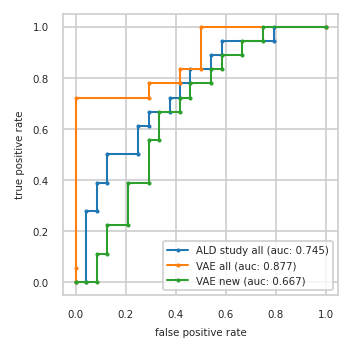

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.278   0.000 0.722   0.083 0.000
3          0.083 0.278   0.292 0.722   0.083 0.111
4          0.083 0.389   0.292 0.778   0.125 0.111
5          0.125 0.389   0.417 0.778   0.125 0.222
6          0.125 0.500   0.417 0.833   0.208 0.222
7          0.250 0.500   0.500 0.833   0.208 0.389
8          0.250 0.611   0.500 1.000   0.292 0.389
9          0.292 0.611   1.000 1.000   0.292 0.556
10         0.292 0.667     NaN   NaN   0.333 0.556
11         0.375 0.667     NaN   NaN   0.333 0.667
12         0.375 0.722     NaN   NaN   0.417 0.667
13         0.417 0.722     NaN   NaN   0.417 0.722
14         0.417 0.778     NaN   NaN   0.458 0.722
15         0.458 0.778     NaN   NaN   0.458 0.778
16         0.458 0.833     NaN   NaN   0.542 0.778
17         0.542 0.833     NaN   NaN   0.542 0.833
18         0.542 0.889     NaN   NaN   0.583 0.833
19         0.583 0.889     NaN   NaN   0.583 0.889
20         0.583 0.944     NaN   NaN   0.667 0.889
21         0.792 0.944     NaN   NaN   0.667 0.944
22         0.792 1.000     NaN   NaN   0.750 0.944
23         1.000 1.000     NaN   NaN   0.750 1.000
24           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q07507,P26572,H0Y7C8;O14657
2,Q9NRN5,A0A1B0GV23;A0A1B0GVD5;A0A1B0GWE8;P07339,P51688
3,P61981,Q9Y2T3;Q9Y2T3-3,P07900;P07900-2
4,Q9Y2T3;Q9Y2T3-3,P14174,P31321
5,Q99983,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
6,P10636-2;P10636-6,P61981,None
7,P14174,Q14894,None
8,P00338;P00338-3,P63104,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


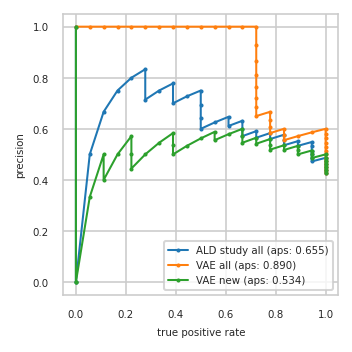

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.533 0.889     0.600 1.000     0.533 0.889
13         0.552 0.889     0.586 0.944     0.517 0.833
14         0.536 0.833     0.571 0.889     0.536 0.833
15         0.556 0.833     0.556 0.833     0.519 0.778
16         0.577 0.833     0.577 0.833     0.538 0.778
17         0.560 0.778     0.600 0.833     0.560 0.778
18         0.583 0.778     0.583 0.778     0.542 0.722
19         0.565 0.722     0.609 0.778     0.565 0.722
20         0.591 0.722     0.636 0.778     0.545 0.667
21         0.571 0.667     0.667 0.778     0.571 0.667
22         0.600 0.667     0.650 0.722     0.600 0.667
23         0.632 0.667     0.684 0.722     0.579 0.611
24         0.611 0.611     0.722 0.722     0.556 0.556
25         0.647 0.611     0.765 0.722     0.588 0.556
26         0.625 0.556     0.812 0.722     0.562 0.500
27         0.600 0.500     0.867 0.722     0.533 0.444
28         0.643 0.500     0.929 0.722     0.500 0.389
29         0.692 0.500     1.000 0.722     0.538 0.389
30         0.750 0.500     1.000 0.667     0.583 0.389
31         0.727 0.444     1.000 0.611     0.545 0.333
32         0.700 0.389     1.000 0.556     0.500 0.278
33         0.778 0.389     1.000 0.500     0.444 0.222
34         0.750 0.333     1.000 0.444     0.500 0.222
35         0.714 0.278     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


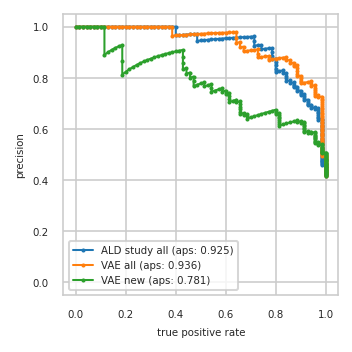

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


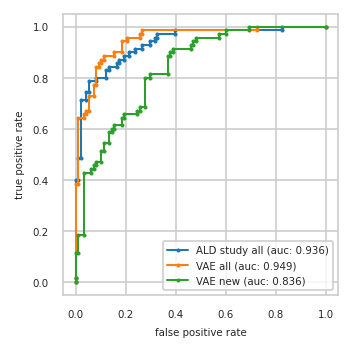

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}